# <span style="font-variant: small-caps"> Big Data </span>

## Assignment 5
zuzan

---

**Task 1** Download the Bank Marketing dataset from Kaggle (https://www.kaggle.com/rouseguy/bankbalanced/data). Using PySpark, build a binary classifier that predicts whether a client will subscribe to a term deposit. Compare different classification algorithms with each other.

---

**Dataset description*:**

1 - age (numeric)

2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - balance

7 - housing: has housing loan? (categorical: 'no','yes','unknown')

8 - loan: has personal loan? (categorical: 'no','yes','unknown')

9 - contact: contact communication type (categorical: 'cellular','telephone')

10 - day

11 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

12 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

17 - deposit - has the client subscribed a term deposit? (binary: 'yes','no')

\* this is a description provided by UCI, regarding the full dataset. The information above might be not 100% consistent with the analyzed data frame.

In [1]:
import findspark
findspark.init()

import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [102]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [2]:
data = spark.read.csv('bank.csv', header=True, inferSchema=True)

In [3]:
data.show(5)

+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job|marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+-------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
| 59|    admin.|married|secondary|     no|   2343|    yes|  no|unknown|  5|  may|    1042|       1|   -1|       0| unknown|    yes|
| 56|    admin.|married|secondary|     no|     45|     no|  no|unknown|  5|  may|    1467|       1|   -1|       0| unknown|    yes|
| 41|technician|married|secondary|     no|   1270|    yes|  no|unknown|  5|  may|    1389|       1|   -1|       0| unknown|    yes|
| 55|  services|married|secondary|     no|   2476|    yes|  no|unknown|  5|  may|     579|       1|   -1|       0| unknown|    yes|
| 54|    admin.|married| tertiary|     no|    184|     no|  no|unknown|  5| 

In [4]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [6]:
data.select('deposit').groupBy('deposit').count().show()  # good, balanced

+-------+-----+
|deposit|count|
+-------+-----+
|    yes| 5289|
|     no| 5873|
+-------+-----+



In [37]:
vector_col = "corr_features"
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int']
assembler = VectorAssembler(inputCols=numeric_features, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

In [11]:
matrix.head()

Row(pearson(corr_features)=DenseMatrix(7, 7, [1.0, 0.1123, -0.0008, 0.0002, -0.0053, 0.0028, 0.0202, 0.1123, ..., 0.5073, 0.0202, 0.0308, -0.059, -0.0267, -0.0497, 0.5073, 1.0], False))

In [9]:
matrix.collect()[0]["pearson({})".format(vector_col)].values   # pretty unreadable

array([ 1.00000000e+00,  1.12299889e-01, -7.62420921e-04,  1.89228074e-04,
       -5.27793616e-03,  2.77383431e-03,  2.01685612e-02,  1.12299889e-01,
        1.00000000e+00,  1.04674395e-02,  2.24361313e-02, -1.38938225e-02,
        1.74111486e-02,  3.08052469e-02, -7.62420921e-04,  1.04674395e-02,
        1.00000000e+00, -1.85113992e-02,  1.37006834e-01, -7.72316130e-02,
       -5.89806835e-02,  1.89228074e-04,  2.24361313e-02, -1.85113992e-02,
        1.00000000e+00, -4.15574588e-02, -2.73915532e-02, -2.67161713e-02,
       -5.27793616e-03, -1.38938225e-02,  1.37006834e-01, -4.15574588e-02,
        1.00000000e+00, -1.02726048e-01, -4.96994980e-02,  2.77383431e-03,
        1.74111486e-02, -7.72316130e-02, -2.73915532e-02, -1.02726048e-01,
        1.00000000e+00,  5.07271588e-01,  2.01685612e-02,  3.08052469e-02,
       -5.89806835e-02, -2.67161713e-02, -4.96994980e-02,  5.07271588e-01,
        1.00000000e+00])

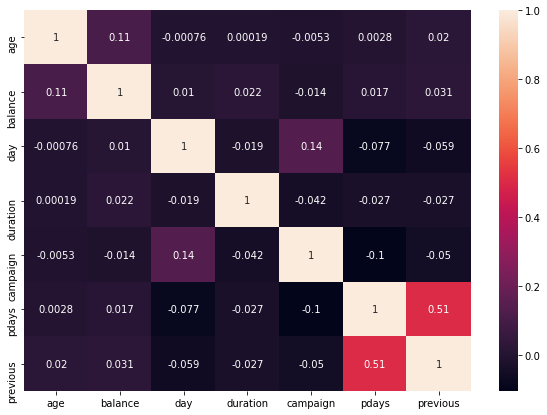

In [38]:
numeric_data = data.select(numeric_features).toPandas()    # no strong correlations betweet features
fig, ax = plt.subplots(figsize=(10,7))  
sn.heatmap(numeric_data.corr(), annot=True)
plt.show()

In [39]:
numeric_data = data.select(numeric_features + ['deposit']).toPandas()  

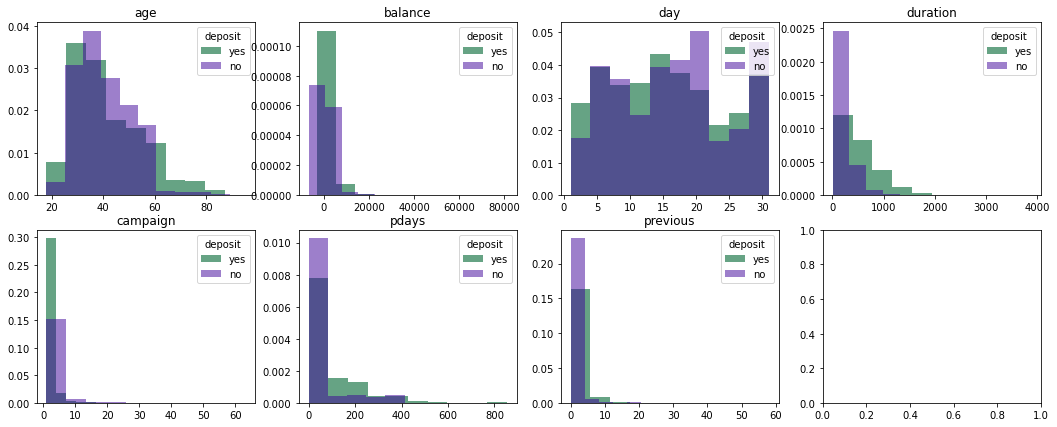

In [90]:
fig, axs = plt.subplots(2,4, figsize=(18,7))
for i, ax in enumerate(fig.axes):
    if i < 7:
        col = numeric_data.columns[i]
        ax.hist(numeric_data[numeric_data.deposit=='yes'][col], alpha=0.6, color='#006633', density=True)
        ax.hist(numeric_data[numeric_data.deposit=='no'][col], alpha=0.5, color='#3D0099', density=True)
        ax.legend(['yes','no'], title='deposit')
        ax.set_title(col)
plt.show()

In [94]:
# how it is with this duration feature?
numeric_data.duration.describe()   # it looks like the attribute description is not really correct

count    11162.000000
mean       371.993818
std        347.128386
min          2.000000
25%        138.000000
50%        255.000000
75%        496.000000
max       3881.000000
Name: duration, dtype: float64

I will include all variables in further modeling.

### Data preparation

In [101]:
# 1. string indexing and one hot encoding for categorical features

pipeline_stages = []

label_indexer = StringIndexer(inputCol = 'deposit', outputCol = 'label')
pipeline_stages += [label_indexer]

categoricalColumns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

for col in categoricalColumns:
    indexer = StringIndexer(inputCol = col, outputCol = col + '_index')
    encoder = OneHotEncoder(inputCols = [indexer.getOutputCol()], outputCols = [col + "_onehot"])
    pipeline_stages += [indexer, encoder]
    

# 2. adding numerical features

numericalColumns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
columns = [col + "_onehot" for col in categoricalColumns] + numericalColumns


# 3. combining all feature columns
assembler = VectorAssembler(inputCols = columns, outputCol = "features")
pipeline_stages += [assembler]

In [103]:
pipeline = Pipeline(stages=pipeline_stages)
pipeline_model = pipeline.fit(data)

In [107]:
df = pipeline_model.transform(data).select(categoricalColumns + numericalColumns + ['features','label'])
df.show()

+-----------+--------+---------+-------+-------+----+-------+-----+--------+---+-------+---+--------+--------+-----+--------+--------------------+-----+
|        job| marital|education|default|housing|loan|contact|month|poutcome|age|balance|day|duration|campaign|pdays|previous|            features|label|
+-----------+--------+---------+-------+-------+----+-------+-----+--------+---+-------+---+--------+--------+-----+--------+--------------------+-----+
|     admin.| married|secondary|     no|    yes|  no|unknown|  may| unknown| 59|   2343|  5|    1042|       1|   -1|       0|(42,[3,11,13,16,1...|  1.0|
|     admin.| married|secondary|     no|     no|  no|unknown|  may| unknown| 56|     45|  5|    1467|       1|   -1|       0|(42,[3,11,13,16,1...|  1.0|
| technician| married|secondary|     no|    yes|  no|unknown|  may| unknown| 41|   1270|  5|    1389|       1|   -1|       0|(42,[2,11,13,16,1...|  1.0|
|   services| married|secondary|     no|    yes|  no|unknown|  may| unknown| 55|  

In [108]:
# spliting into training and testing sets
train, test = df.randomSplit([0.8, 0.2], seed = 1)

### Decision Tree

In [143]:
from pyspark.ml.classification import DecisionTreeClassifier
tree = DecisionTreeClassifier(featuresCol='features', labelCol='label')

In [144]:
# grid search
from pyspark.ml.tuning import ParamGridBuilder
param_grid = ParamGridBuilder().addGrid(tree.maxDepth, [2,4,6,8,10]).build()

In [145]:
# evaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
binary_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

In [146]:
#build cross-validation model
from pyspark.ml.tuning import CrossValidator
cv = CrossValidator(estimator=tree, estimatorParamMaps=param_grid, evaluator=binary_evaluator, numFolds=5)

In [147]:
model = cv.fit(train)

In [148]:
for param, metrics in zip(param_grid, model.avgMetrics):
    print('Max depth:', param.values(), ' Area Under ROC:', metrics)  # just inspecting auc for different hiperparameters

Max depth: dict_values([2])  Area Under ROC: 0.6748088549834059
Max depth: dict_values([4])  Area Under ROC: 0.7388636036654854
Max depth: dict_values([6])  Area Under ROC: 0.7522468427901274
Max depth: dict_values([8])  Area Under ROC: 0.7309895700674889
Max depth: dict_values([10])  Area Under ROC: 0.6949952476517853


In [149]:
model.bestModel   # the tree of depth 6 will be chosen as the best model

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_92cf17c9ecce, depth=6, numNodes=75, numClasses=2, numFeatures=42

In [150]:
prediction_tree = model.transform(test)

In [155]:
prediction_tree.select(['features','label','probability','prediction']).show(5)

+--------------------+-----+--------------------+----------+
|            features|label|         probability|prediction|
+--------------------+-----+--------------------+----------+
|(42,[3,15,16,18,2...|  0.0|[0.86558805227131...|       0.0|
|(42,[3,13,16,17,1...|  1.0|[0.08682170542635...|       1.0|
|(42,[3,13,16,17,1...|  1.0|[0.23561346362649...|       1.0|
|(42,[3,13,16,17,1...|  0.0|[0.31431431431431...|       1.0|
|(42,[3,13,16,17,1...|  1.0|[0.86558805227131...|       0.0|
+--------------------+-----+--------------------+----------+
only showing top 5 rows



In [156]:
# confusion matrix
prediction_tree.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  989|
|  1.0|       1.0|  833|
|  0.0|       1.0|  188|
|  1.0|       0.0|  204|
+-----+----------+-----+



In [157]:
# accuracy
(989 + 833) / (989 + 833 + 188 + 204)

0.8229448961156278

### Random Forest

In [170]:
from pyspark.ml.classification import RandomForestClassifier

forest = RandomForestClassifier(featuresCol='features', labelCol='label')
param_grid = ParamGridBuilder().addGrid(forest.numTrees, [50,100]).addGrid(forest.maxDepth, [4,6,8]).build()
binary_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
cv = CrossValidator(estimator=forest, estimatorParamMaps=param_grid, evaluator=binary_evaluator, numFolds=5)

model = cv.fit(train)

In [174]:
for param, metrics in zip(param_grid, model.avgMetrics):
    print('Number of trees, max depth:', param.values(), ' Area Under ROC:', metrics) 

Number of trees, max depth: dict_values([50, 4])  Area Under ROC: 0.8824059611982712
Number of trees, max depth: dict_values([50, 6])  Area Under ROC: 0.8990035446548217
Number of trees, max depth: dict_values([50, 8])  Area Under ROC: 0.9090165057577586
Number of trees, max depth: dict_values([100, 4])  Area Under ROC: 0.8840727512484519
Number of trees, max depth: dict_values([100, 6])  Area Under ROC: 0.9009052085546191
Number of trees, max depth: dict_values([100, 8])  Area Under ROC: 0.9106272914512146


In [175]:
model.bestModel  # best model for 100 trees and depth 8

RandomForestClassificationModel: uid=RandomForestClassifier_1c98a62c2012, numTrees=100, numClasses=2, numFeatures=42

In [176]:
prediction_forest = model.transform(test)

In [177]:
# confusion matrix
prediction_forest.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|  972|
|  1.0|       1.0|  881|
|  0.0|       1.0|  205|
|  1.0|       0.0|  156|
+-----+----------+-----+



In [178]:
# accuracy
(972 + 881) / (972 + 881 + 205 + 156)

0.8369467028003613

Even though random forest shows better performance of fitting to the train data (comparing area under ROC), the accuracy of prediction on the test data is only slightly better.

### Logistic regression

In [196]:
from pyspark.ml.classification import LogisticRegression

logistic = LogisticRegression(maxIter=20)
model = logistic.fit(train)

area under ROC (for training set): 0.9045576407775238


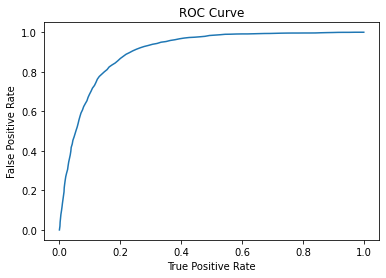

In [197]:
print('area under ROC (for training set): ' + str(model.summary.areaUnderROC))

roc = model.summary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [198]:
prediction_logistic = model.transform(test)

In [199]:
# confusion matrix
prediction_logistic.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1011|
|  1.0|       1.0|  814|
|  1.0|       0.0|  223|
|  0.0|       1.0|  166|
+-----+----------+-----+



In [200]:
(1011 + 814) / (1011 + 814 + 223 + 166)

0.8242999096657633

Accuracy comparable with decision tree (slightly better).

### Gradient Boosted Tree classifier

In [209]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(maxIter=20, maxDepth=6)
model = gbt.fit(train)

In [210]:
# area under roc curve for training set
binary_evaluator.evaluate(model.transform(train))

0.9506866995950202

In [211]:
prediction_gbt = model.transform(test)

In [212]:
# confusion matrix
prediction_gbt.groupBy('label','prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0| 1003|
|  1.0|       1.0|  901|
|  0.0|       1.0|  174|
|  1.0|       0.0|  136|
+-----+----------+-----+



In [213]:
# accuracy
(1003 + 901) / (1003 + 901 + 174 + 136)

0.8599819331526649

In terms of accuracy for test data, GBT classifier is the best one!